Computing Undamped Exact Solution ...
Computing Undamped Numerical Solutions ...
Computing Damped Numerical Solution ...
Computing Crank-Nicholson Solution ...


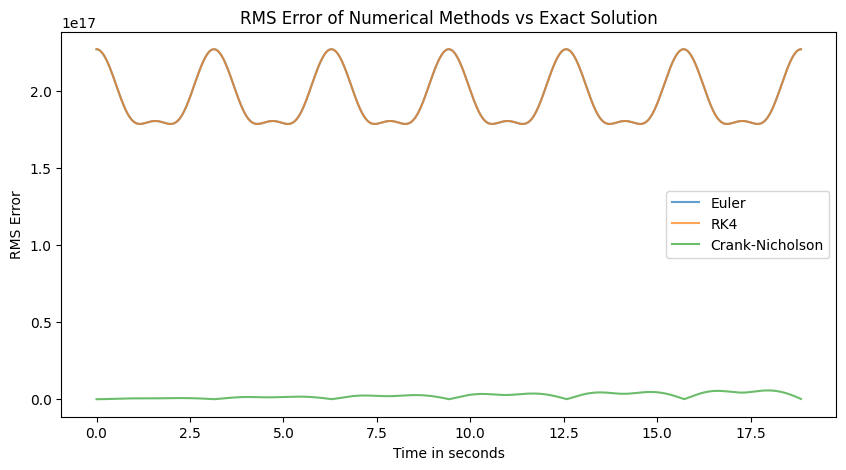

In [7]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt

#store psi as Nx1 array, full solution stored as NxM (N positions, M timesteps)
m = 1
hBar = 1.055e-34 # Reduced Planck's Constant in J * s
omega = 1
C_n = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)] # initial values of first three eigenstates
average_n = (np.dot(C_n,np.arange(1,4)))/3.0 # average energy level, used to get classical turning point 
N = 201
M = 3000
T = 3*2*np.pi/omega # run for 10 times the period of the harmonic oscillator
x_classical_turning_point = np.sqrt((2*average_n+1)*(hBar/(m*omega)))
x_max = x_classical_turning_point*5.0
x_vec = np.linspace(-x_max, x_max, N)
t_vec = np.linspace(0,T,M)
dt = t_vec[1]-t_vec[0]
h =(2*x_max)/(N-1)
alpha = 0.1

def generate_initial_state():
    # get initial psi
    return psi

def euler_step(psi, dpsi_dt_function, t, dt):
    return psi + dpsi_dt_function(psi, x_vec, t)*dt
def runge_kutta_step(psi, dpsi_dt_function, t, dt):
    k1 = dt * dpsi_dt_function(psi, x_vec, t)
    k2 = dt * dpsi_dt_function((psi + (0.5 * k1)), x_vec, (t + (0.5 * dt)))
    k3 = dt * dpsi_dt_function((psi + (0.5 * k2)), x_vec, (t + (0.5 * dt)))
    k4 = dt * dpsi_dt_function((psi + k3), x_vec, (t + dt))

    psi_next = psi + ((k1 + (2 * k2) + (2 * k3) + k4) / 6)

    return psi_next

def dpsi_dt_undamped(psi, x, t):
    # Second derivative of the wavefunction psi
    d2psi_dx2 = np.zeros_like(psi)
    for i in range(1, len(x) - 1):  # Exclude boundaries for derivative calculation
        d2psi_dx2[i] = (psi[i+1] - 2*psi[i] + psi[i-1]) / (h**2)
    
    dpsidt = (-1j / hBar) * (- (hBar**2 / (2 * m)) * d2psi_dx2 + (0.5 * m * omega**2 * x**2) * psi)

    return dpsidt

def dpsi_dt_damped(psi, x, t):
    d2psi_dx2 = np.zeros_like(psi)
    for i in range(1, len(x) - 1):  
        d2psi_dx2[i] = (psi[i+1] - 2*psi[i] + psi[i-1]) / (h**2)
    
    kinetic_term = (- (hBar**2 / (2 * m)) * d2psi_dx2) * np.exp(-alpha * t) # The kinetic term of the full derivative
    potential_term = (0.5 * m * omega**2 * x**2 * psi) * np.exp(alpha * t) # The potential term of the full derivative

    dpsidt = (-1j / hBar) * (kinetic_term + potential_term)

    return dpsidt

def rms_error(P1, P2):
    error = np.zeros(M)
    Delta_P = P1 - P2
    for i in range(M):
        error[i] = np.sqrt(np.sum( (Delta_P[:,i])**2 ))
    return error

def expected_position(psi):
    x_bar = np.zeros(M)
    a = x_vec[0]
    b = x_vec[-1]
    k = np.arange(1,)
    for i in range(M):
        f = np.abs(psi[:,i])**2*np.transpose(x_vec)
        psi_i = psi[:,i]
        x_bar[i] = h/3*( f[0]+f[-1]+4*np.sum(f[1:-1:2])+2*np.sum(f[2:-2:2]) )
    return x_bar

#def time_dependent_solution():
def E_n(n):
    return (n+0.5)*hBar*omega
def eigenstate_solution():
    psi = np.zeros((N,M),np.complex128)
    for i in range(M):
        t = t_vec[i]
        psi[:,i] += np.exp(-1.0j*E_n(0)*t/hBar)*C_n[0]*(m*omega/np.pi/hBar)**0.25*np.exp(-m*omega*x_vec**2.0/(2*hBar))
        psi[:,i] += np.exp(-1.0j*E_n(1)*t/hBar)*C_n[1]*(4/np.pi*(m*omega/hBar)**3)**0.25*x_vec*np.exp(-m*omega*x_vec**2.0/(2*hBar))
        psi[:,i] += np.exp(-1.0j*E_n(2)*t/hBar)*C_n[2]*(m*omega/4/np.pi/hBar)**0.25*(2*m*omega/hBar*x_vec**2.0-1)*np.exp(-m*omega*x_vec**2.0/2/hBar)
    return psi # N x M for N points, M timesteps

print("Computing Undamped Exact Solution ...")
psi_eigenstates = eigenstate_solution()

print("Computing Undamped Numerical Solutions ...")
psi_undamped_euler = np.zeros_like(psi_eigenstates, np.complex128)
psi_undamped_euler[:,0] = psi_eigenstates[:,0]
psi_undamped_rk4 = psi_undamped_euler.copy()
for i in range(M):
    psi_undamped_euler[0,i-1] = 0.0
    psi_undamped_euler[-1,i-1] = 0.0
    psi_undamped_rk4[0,i-1] = 0.0
    psi_undamped_rk4[-1,i-1] = 0.0
    psi_undamped_euler[:,i] = euler_step(psi_undamped_euler[:,i-1], dpsi_dt_undamped, t_vec[i], dt)
    psi_undamped_rk4[:,i] = runge_kutta_step(psi_undamped_rk4[:,i-1], dpsi_dt_undamped, t_vec[i], dt)
P_eigenstates = np.abs(psi_eigenstates)**2
P_undamped_euler = np.abs(psi_undamped_euler)**2
P_undamped_rk4 = np.abs(psi_undamped_rk4)**2
error_undamped_euler = rms_error(P_eigenstates, P_undamped_euler)
error_undamped_rk4 = rms_error(P_eigenstates, P_undamped_rk4)
x_bar_eigenstates = expected_position(psi_eigenstates)
x_bar_undamped_euler = expected_position(psi_undamped_euler)
x_bar_undamped_rk4 = expected_position(psi_undamped_rk4)

print("Computing Damped Numerical Solution ...")
psi_damped = np.zeros_like(psi_eigenstates, np.complex128)
psi_damped[:,0] = psi_eigenstates[:,0]
for i in range(1,M):
    psi_damped[0,i-1] = 0.0
    psi_damped[-1,i-1] = 0.0
    psi_damped[:,i] = runge_kutta_step(psi_damped[:,i-1], dpsi_dt_damped, t_vec[i], dt)
P_damped = np.abs(psi_damped)**2
x_bar_damped = expected_position(psi_damped)
    
#solve time dependent equation for damped case

def construct_hamiltonian(N, h, m, omega, hBar, x_vec):
    
    #kinetic energy operator approximated by finite difference using a tridiagonal matrix
    kinetic_main = -2.0 * np.ones(N)
    kinetic_off = 1.0 * np.ones(N - 1)
    kinetic = diags([kinetic_off, kinetic_main, kinetic_off], [-1, 0, 1]) / (h ** 2)
    kinetic *= -(hBar ** 2) / (2 * m)

    #v(x) as a diagonal matrix
    potential = 0.5 * m * omega**2 * x_vec**2
    potential_matrix = diags(potential, 0)
    
    #final hamiltonian/ total energy operator for TDSE
    H = kinetic + potential_matrix
    return H.tocsc()  
    #sparse column format for solving

def crank_nicholson_step(psi_n, H, dt, hBar):
    I = diags([1.0] * len(psi_n), 0, format='csc')
    #A is left hand side matrix
    A = I + (1j * dt / (2 * hBar)) * H
    B = I - (1j * dt / (2 * hBar)) * H
    #right hand side vector
    rhs = B @ psi_n
    psi_np1 = spsolve(A, rhs)
    return psi_np1

print("Computing Crank-Nicholson Solution ...")
H = construct_hamiltonian(N, h, m, omega, hBar, x_vec)

#storing over all time steps
psi_crank = np.zeros_like(psi_eigenstates, dtype=np.complex128)
psi_crank[:, 0] = psi_eigenstates[:, 0]

#boundary conditions set to 0
for i in range(1, M):
    psi_crank[0, i-1] = 0.0
    psi_crank[-1, i-1] = 0.0
    psi_next = crank_nicholson_step(psi_crank[:, i-1], H, dt, hBar)
    psi_next[0] = 0.0
    psi_next[-1] = 0.0
    psi_crank[:, i] = psi_next

P_crank = np.abs(psi_crank)**2
error_undamped_crank = rms_error(P_eigenstates, P_crank)
x_bar_crank = expected_position(psi_crank)

# Plotting RMS error for all methods
#slowly accumulates error over time
plt.figure(figsize=(10,5))
plt.plot(t_vec, error_undamped_euler, label='Euler', alpha=0.7)
plt.plot(t_vec, error_undamped_rk4, label='RK4', alpha=0.7)
plt.plot(t_vec, error_undamped_crank, label='Crank-Nicholson', alpha=0.7)
plt.xlabel("Time in seconds")
plt.ylabel("RMS Error")
plt.title("RMS Error of Numerical Methods vs Exact Solution")
plt.legend()



